 * @ Author: Yohei Ohto
 * @ Create Time: 2025-05-28 14:07:54
 * @ Modified time: 2025-05-28 14:08:02
 * @ Description: distance from pareto with dataset

In [1]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import collections
import itertools
import random
import time
import warnings
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
# import umap
import xgboost as xgb
# from deap import algorithms, base, creator, tools
# from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from scipy.stats import norm
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score)
from tqdm import tqdm
from util import pickle_load, robust_z, pickle_dump

warnings.filterwarnings("ignore")

import math
from math import comb

import xgboost as xgb
from scipy.stats import pearsonr
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, auc,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)

/opt/250102_test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
test_num = "0702"
lig = "ago"
date = 241219
num = 1
seed = 42

In [11]:
if test_num in ["0701", "0702", "0907", "1001", "1002"]:
    if lig == "ago":
        lig = "!"
    else:
        pass
trys = str(date) + "_" + str(num)

if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num

# run toxicity prediction

In [ ]:
pareto = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/pareto_front.tsv", sep="\t", header=None)
top5 = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv", sep="\t", header=None)
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75d5a43bae50>>
Traceback (most recent call last):
  File "/opt/250102_test_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
import ast
from tqdm import tqdm

all_individuals = list()
for i in tqdm(range(len(top5))):
    for n in range(len(top5.columns)):
        try:
            all_individuals.append(ast.literal_eval(top5.iloc[i,n].replace("Individual(", "").replace(")", "")))
        except:
            continue

IND_INIT_SIZE = len(val)
unique_individuals = [set(fs) for fs in set(frozenset(s) for s in all_individuals)]
unique_list = [u for u in unique_individuals if len(u) == IND_INIT_SIZE]
print(len(unique_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s]


13300


: 

In [ ]:
all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

if len(set(all_toxs)) == 2:
    tox_scoring = "descrete"
else:
    tox_scoring = "continuous"

if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "descrete":
    standardized_toxs = all_toxs

def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

: 

In [7]:
random_pops = []
random_smiles_pops = []
count = 0
IND_INIT_SIZE = len(val)

now = time.ctime()
cnvtime = time.strptime(now)

progress_bar = tqdm(total=100, desc="Processing")

while count < 100:
    a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
    a = set(a)
    while len(a) != IND_INIT_SIZE:
        a.add(random.randint(0, len(cas_tox)-1))
    score_moo = multi_objective_optimization(a)
    random_smiles_pops.append(list(a))
    random_pops.append([score_moo[0], score_moo[1], score_moo[2]])
    progress_bar.update(1)
    count += 1

progress_bar.close()


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing: 100%|██████████| 100/100 [00:00<00:00, 156.85it/s]


In [8]:
ga_pops = []
ga_smiles_pops = []
for i in tqdm(range(len(unique_list))):
    a = unique_list[i]
    if len(a) != IND_INIT_SIZE:
        continue
    score_moo = multi_objective_optimization(a)
    if score_moo[0] == 100000 or score_moo[1] == -100000 or score_moo[2] == -100000:
        continue
    ga_smiles_pops.append(list(a))
    ga_pops.append([score_moo[0], score_moo[1], score_moo[2]])

100%|██████████| 13300/13300 [01:10<00:00, 189.41it/s]


In [9]:
pareto_pops = []
pareto_smiles_pops = []
for i in range(len(pareto)):
    pop = [pareto.iloc[i,n] for n in range(len(pareto.iloc[i]))]
    score_moo = multi_objective_optimization(pop)
    pareto_pops.append([score_moo[0], score_moo[1], score_moo[2]])
    pareto_smiles_pops.append(list(pop))

In [10]:
print(len(random_pops), len(ga_pops), len(pareto_pops))

100 13300 63


In [11]:
random_pops = np.array(random_pops)
ga_pops = np.array(ga_pops)
pareto_pops = np.array(pareto_pops)

shortest_distances_random = []
for pop in tqdm(random_pops):
    distances = np.linalg.norm(pareto_pops - pop, axis=1)
    shortest_distance = np.min(distances)
    if shortest_distance > 10000:
        continue
    shortest_distances_random.append(shortest_distance)

shortest_distances_ga = []
for pop in tqdm(ga_pops):
    distances = np.linalg.norm(pareto_pops - pop, axis=1)
    shortest_distance = np.min(distances)
    if shortest_distance > 10000:
        continue
    shortest_distances_ga.append(shortest_distance)

shortest_distances_pareto = []
for pop in tqdm(pareto_pops):
    distances = np.linalg.norm(pareto_pops - pop, axis=1)
    shortest_distance = np.min(distances)
    if shortest_distance > 10000:
        continue
    shortest_distances_pareto.append(shortest_distance)

100%|██████████| 63/63 [00:00<00:00, 84774.19it/s]


In [2]:
def sample_extremely_non_uniformly_with_indices(data, num_samples, exponent=0.2):
    n = len(data)
    if n == 0 or num_samples <= 0:
        return [], []
    num_samples = min(num_samples, n)

    indexed_data_arr = np.array(
        list(enumerate(data)),
        dtype=[('index', int), ('value', float)]
    )
    s_sorted = np.sort(indexed_data_arr, order='value')
    
    uniform_points = np.linspace(0, 1, num_samples)

    scaled_indices_to_sample = np.power(uniform_points, exponent) * (n - 1)
    
    sample_indices_in_sorted = np.round(scaled_indices_to_sample).astype(int)
    sample_indices_in_sorted = np.clip(sample_indices_in_sorted, 0, n - 1)

    selected_pairs = s_sorted[sample_indices_in_sorted]
    sampled_values = selected_pairs['value'].tolist()
    original_indices = selected_pairs['index'].tolist()

    return sampled_values, original_indices

In [13]:
sampled_ga_distances, sampled_ga_indices = sample_extremely_non_uniformly_with_indices(shortest_distances_ga, 100)
sampled_ga_smiles = [ga_smiles_pops[i] for i in sampled_ga_indices]
sampled_ga_pops = [ga_pops[i] for i in sampled_ga_indices]

(array([1., 3., 5., 5., 3., 4., 2., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2.,
        2., 3., 2., 3., 3., 3., 4., 3., 4., 3., 4., 3., 3., 4., 3., 3., 2.,
        3., 2., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.        ,  1.93738901,  3.87477803,  5.81216704,  7.74955605,
         9.68694506, 11.62433408, 13.56172309, 15.4991121 , 17.43650111,
        19.37389013, 21.31127914, 23.24866815, 25.18605716, 27.12344618,
        29.06083519, 30.9982242 , 32.93561321, 34.87300223, 36.81039124,
        38.74778025, 40.68516926, 42.62255828, 44.55994729, 46.4973363 ,
        48.43472532, 50.37211433, 52.30950334, 54.24689235, 56.18428137,
        58.12167038, 60.05905939, 61.9964484 , 63.93383742, 65.87122643,
        67.80861544, 69.74600445, 71.68339347, 73.62078248, 75.55817149,
        77.4955605 , 79.43294952, 81.37033853, 83.30772754, 85.24511656,
        87.18250557, 89.11989458, 91.05728359, 92.99467261, 94.93206162,
        96.86945063]),
 <BarContainer object

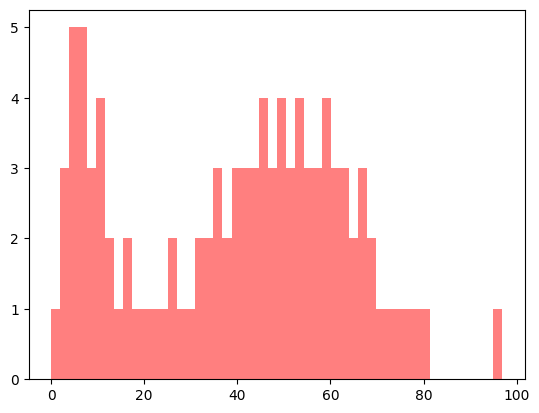

In [14]:
plt.hist(sampled_ga_distances, bins=50, alpha=0.5, label='GA', color='red')
# plt.hist(shortest_distances_random, bins=bins, alpha=0.5, label='Random', color='blue')

In [15]:
all_X = []
all_y = []

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

for i in range(len(cas_tox)):
    mol = Chem.MolFromSmiles(cas_tox.iloc[i, 2])
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        all_X.append(fp)
        all_y.append(cas_tox.iloc[i, 1])
    else:
        print(f"Warning: Could not parse SMILES at index {i}: {cas_tox.iloc[i, 2]}")
        all_X.append(None)

In [16]:
valid_indices = [i for i, x in enumerate(all_X) if x is not None]
all_X = [all_X[i] for i in valid_indices]
all_y = [all_y[i] for i in valid_indices]
all_indices = set(range(len(all_X)))

In [17]:
model_params = {'tree_method': 'hist', 'device': 'cuda'}

In [19]:
if tox_scoring == "continuous":
    model_class = xgb.XGBRegressor
    metrics_ga = {'mse': [], 'mae': [], 'r2': []}
    metric_funcs = {
        'mse': mean_squared_error,
        'mae': mean_absolute_error,
        'r2': r2_score
    }

elif tox_scoring == "descrete":
    model_class = xgb.XGBClassifier
    metrics_ga = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    metric_funcs = {
        'accuracy': accuracy_score,
        'precision': lambda y_t, y_p, **kwargs: precision_score(y_t, y_p, zero_division=0, **kwargs),
        'recall': lambda y_t, y_p, **kwargs: recall_score(y_t, y_p, zero_division=0, **kwargs),
        'f1': lambda y_t, y_p, **kwargs: f1_score(y_t, y_p, zero_division=0, **kwargs),
        'auc': roc_auc_score
    }
    
y_preds_ga = []
k = 0
for pop in tqdm(sampled_ga_smiles, desc="Processing pops"):
    k += 1
    if k == 2:
        break
    pred_indices = set(pop) & all_indices 
    if not pred_indices:
        print(f"Skipping empty or invalid pop: {pop}")
        for key in metrics_ga:
            metrics_ga[key].append(None) 
        continue

    train_indices = list(all_indices - pred_indices)
    if not train_indices or not pred_indices:
        print(f"Skipping pop due to empty train/pred set: {pop}")
        for key in metrics_ga:
            metrics_ga[key].append(None)
        continue

    X_train_new = [all_X[i] for i in train_indices]
    y_train_new = [all_y[i] for i in train_indices]
    
    X_pred_new = [all_X[i] for i in pred_indices]
    y_true = [all_y[i] for i in pred_indices]

    model = model_class(**model_params)
    model.fit(X_train_new, y_train_new)
    
    y_pred = model.predict(X_pred_new)
    y_preds_ga.append(y_pred)

    if tox_scoring == "continuous":
        metrics_ga['mse'].append(metric_funcs['mse'](y_true, y_pred))
        metrics_ga['mae'].append(metric_funcs['mae'](y_true, y_pred))
        metrics_ga['r2'].append(metric_funcs['r2'](y_true, y_pred))

    elif tox_scoring == "descrete":
        y_proba = model.predict_proba(X_pred_new)[:, 1]
        metrics_ga['accuracy'].append(metric_funcs['accuracy'](y_true, y_pred))
        metrics_ga['precision'].append(metric_funcs['precision'](y_true, y_pred))
        metrics_ga['recall'].append(metric_funcs['recall'](y_true, y_pred))
        metrics_ga['f1'].append(metric_funcs['f1'](y_true, y_pred))
        try:
            if len(set(y_true)) < 2:
                 metrics_ga['auc'].append(0.5)
            else:
                metrics_ga['auc'].append(metric_funcs['auc'](y_true, y_proba))
        except Exception as e:
            print(f"AUC calculation error for pop {pop}: {e}")
            metrics_ga['auc'].append(0.5)

Processing pops:   1%|          | 1/100 [01:44<2:52:43, 104.68s/it]


In [ ]:
if tox_scoring == "continuous":
    model_class = xgb.XGBRegressor
    metrics_random = {'mse': [], 'mae': [], 'r2': []}
    metric_funcs = {
        'mse': mean_squared_error,
        'mae': mean_absolute_error,
        'r2': r2_score
    }

elif tox_scoring == "descrete":
    model_class = xgb.XGBClassifier
    metrics_random = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    metric_funcs = {
        'accuracy': accuracy_score,
        'precision': lambda y_t, y_p, **kwargs: precision_score(y_t, y_p, zero_division=0, **kwargs),
        'recall': lambda y_t, y_p, **kwargs: recall_score(y_t, y_p, zero_division=0, **kwargs),
        'f1': lambda y_t, y_p, **kwargs: f1_score(y_t, y_p, zero_division=0, **kwargs),
        'auc': roc_auc_score
    }

y_preds_random = []
for pop in tqdm(random_smiles_pops, desc="Processing pops"):
    pred_indices = set(pop) & all_indices 
    if not pred_indices:
        print(f"Skipping empty or invalid pop: {pop}")
        for key in metrics_random:
            metrics_random[key].append(None) 
        continue

    train_indices = list(all_indices - pred_indices)
    if not train_indices or not pred_indices:
        print(f"Skipping pop due to empty train/pred set: {pop}")
        for key in metrics_random:
            metrics_random[key].append(None)
        continue

    X_train_new = [all_X[i] for i in train_indices]
    y_train_new = [all_y[i] for i in train_indices]
    
    X_pred_new = [all_X[i] for i in pred_indices]
    y_true = [all_y[i] for i in pred_indices]

    model = model_class(**model_params)
    model.fit(X_train_new, y_train_new)
    
    y_pred = model.predict(X_pred_new)
    y_preds_random.append(y_pred)

    if tox_scoring == "continuous":
        metrics_random['mse'].append(metric_funcs['mse'](y_true, y_pred))
        metrics_random['mae'].append(metric_funcs['mae'](y_true, y_pred))
        metrics_random['r2'].append(metric_funcs['r2'](y_true, y_pred))

    elif tox_scoring == "descrete":
        y_proba = model.predict_proba(X_pred_new)[:, 1]
        metrics_random['accuracy'].append(metric_funcs['accuracy'](y_true, y_pred))
        metrics_random['precision'].append(metric_funcs['precision'](y_true, y_pred))
        metrics_random['recall'].append(metric_funcs['recall'](y_true, y_pred))
        metrics_random['f1'].append(metric_funcs['f1'](y_true, y_pred))
        try:
            if len(set(y_true)) < 2:
                metrics_random['auc'].append(0.5)
            else:
                metrics_random['auc'].append(metric_funcs['auc'](y_true, y_proba))
        except Exception as e:
            print(f"AUC calculation error for pop {pop}: {e}")
            metrics_random['auc'].append(0.5)

In [ ]:
if tox_scoring == "continuous":
    model_class = xgb.XGBRegressor
    metrics_pareto = {'mse': [], 'mae': [], 'r2': []}
    metric_funcs = {
        'mse': mean_squared_error,
        'mae': mean_absolute_error,
        'r2': r2_score
    }

elif tox_scoring == "descrete":
    model_class = xgb.XGBClassifier
    metrics_pareto = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    metric_funcs = {
        'accuracy': accuracy_score,
        'precision': lambda y_t, y_p, **kwargs: precision_score(y_t, y_p, zero_division=0, **kwargs),
        'recall': lambda y_t, y_p, **kwargs: recall_score(y_t, y_p, zero_division=0, **kwargs),
        'f1': lambda y_t, y_p, **kwargs: f1_score(y_t, y_p, zero_division=0, **kwargs),
        'auc': roc_auc_score
    }

y_preds_pareto = []
for pop in tqdm(pareto_smiles_pops, desc="Processing pops"):
    pred_indices = set(pop) & all_indices 
    if not pred_indices:
        print(f"Skipping empty or invalid pop: {pop}")
        for key in metrics_pareto:
            metrics_pareto[key].append(None) 
        continue

    train_indices = list(all_indices - pred_indices)
    if not train_indices or not pred_indices:
        print(f"Skipping pop due to empty train/pred set: {pop}")
        for key in metrics_pareto:
            metrics_pareto[key].append(None)
        continue

    X_train_new = [all_X[i] for i in train_indices]
    y_train_new = [all_y[i] for i in train_indices]
    
    X_pred_new = [all_X[i] for i in pred_indices]
    y_true = [all_y[i] for i in pred_indices]

    model = model_class(**model_params)
    model.fit(X_train_new, y_train_new)
    
    y_pred = model.predict(X_pred_new)
    y_preds_pareto.append(y_pred)

    if tox_scoring == "continuous":
        metrics_pareto['mse'].append(metric_funcs['mse'](y_true, y_pred))
        metrics_pareto['mae'].append(metric_funcs['mae'](y_true, y_pred))
        metrics_pareto['r2'].append(metric_funcs['r2'](y_true, y_pred))

    elif tox_scoring == "descrete":
        y_proba = model.predict_proba(X_pred_new)[:, 1]
        metrics_pareto['accuracy'].append(metric_funcs['accuracy'](y_true, y_pred))
        metrics_pareto['precision'].append(metric_funcs['precision'](y_true, y_pred))
        metrics_pareto['recall'].append(metric_funcs['recall'](y_true, y_pred))
        metrics_pareto['f1'].append(metric_funcs['f1'](y_true, y_pred))
        try:
            if len(set(y_true)) < 2:
                metrics_pareto['auc'].append(0.5)
            else:
                metrics_pareto['auc'].append(metric_funcs['auc'](y_true, y_proba))
        except Exception as e:
            print(f"AUC calculation error for pop {pop}: {e}")
            metrics_pareto['auc'].append(0.5)

In [ ]:
os.makedirs(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga", exist_ok=True)
pickle_dump(metrics_ga, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/metrics_ga.pickle")
pickle_dump(sampled_ga_smiles, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/sampled_ga_smiles.pickle")
pickle_dump(sampled_ga_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/sampled_ga_pops.pickle")
pickle_dump(shortest_distances_ga, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/shortest_distances_ga.pickle")

os.makedirs(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random", exist_ok=True)
pickle_dump(metrics_random, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/metrics_random.pickle")
pickle_dump(random_smiles_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/random_smiles_pops.pickle")
pickle_dump(random_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/random_pops.pickle")
pickle_dump(shortest_distances_random, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/shortest_distances_random.pickle")

os.makedirs(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto", exist_ok=True)
pickle_dump(metrics_pareto, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/metrics_pareto.pickle")
pickle_dump(pareto_smiles_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/pareto_smiles_pops.pickle")
pickle_dump(pareto_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/pareto_pops.pickle")
pickle_dump(shortest_distances_pareto, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/shortest_distances_pareto.pickle")

# run all test

In [4]:
for test_num in tqdm(["0701", "0702", "0901", "0902", "0904", "0905", "0907", "1001", "1002"]): # "0701", "0702", 
    for lig in ["ago", "anta"]:
        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue
        
        seed = 42
        date = 241219
        num = 1

        trys = str(date) + "_" + str(num)

        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num

        pareto = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/pareto_front.tsv", sep="\t", header=None)
        top5 = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv", sep="\t", header=None)
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")

        num_pareto = len(pareto)

        all_individuals = list()
        for i in tqdm(range(len(top5))):
            for n in range(len(top5.columns)):
                try:
                    all_individuals.append(ast.literal_eval(top5.iloc[i,n].replace("Individual(", "").replace(")", "")))
                except:
                    continue

        IND_INIT_SIZE = len(val)
        unique_individuals = [set(fs) for fs in set(frozenset(s) for s in all_individuals)]
        unique_list = [u for u in unique_individuals if len(u) == IND_INIT_SIZE]

        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        random_pops = []
        random_smiles_pops = []
        count = 0
        while count < num_pareto:
            a = [random.randint(0, len(cas_tox)-1) for i in range(len(val))]
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            random_smiles_pops.append(list(a))
            random_pops.append([score_moo[0], score_moo[1], score_moo[2]])
            count += 1

        ga_pops = []
        ga_smiles_pops = []
        for i in tqdm(range(len(unique_list))):
            a = unique_list[i]
            if len(a) != IND_INIT_SIZE:
                continue
            score_moo = multi_objective_optimization(a)
            if score_moo[0] == 100000 or score_moo[1] == -100000 or score_moo[2] == -100000:
                continue
            ga_smiles_pops.append(list(a))
            ga_pops.append([score_moo[0], score_moo[1], score_moo[2]])

        pareto_pops = []
        pareto_smiles_pops = []
        for i in range(len(pareto)):
            pop = [pareto.iloc[i,n] for n in range(len(pareto.iloc[i]))]
            score_moo = multi_objective_optimization(pop)
            pareto_pops.append([score_moo[0], score_moo[1], score_moo[2]])
            pareto_smiles_pops.append(list(pop))

        random_pops = np.array(random_pops)
        ga_pops = np.array(ga_pops)
        pareto_pops = np.array(pareto_pops)

        shortest_distances_random = []
        for pop in tqdm(random_pops):
            distances = np.linalg.norm(pareto_pops - pop, axis=1)
            shortest_distance = np.min(distances)
            if shortest_distance > 10000:
                continue
            shortest_distances_random.append(shortest_distance)

        shortest_distances_ga = []
        for pop in tqdm(ga_pops):
            distances = np.linalg.norm(pareto_pops - pop, axis=1)
            shortest_distance = np.min(distances)
            if shortest_distance > 10000:
                continue
            shortest_distances_ga.append(shortest_distance)

        shortest_distances_pareto = []
        for pop in tqdm(pareto_pops):
            distances = np.linalg.norm(pareto_pops - pop, axis=1)
            shortest_distance = np.min(distances)
            if shortest_distance > 10000:
                continue
            shortest_distances_pareto.append(shortest_distance)
    
        sampled_ga_distances, sampled_ga_indices = sample_extremely_non_uniformly_with_indices(shortest_distances_ga, 100)
        sampled_ga_smiles = [ga_smiles_pops[i] for i in sampled_ga_indices]
        sampled_ga_pops = [ga_pops[i] for i in sampled_ga_indices]

        all_X = []
        all_y = []

        from rdkit import RDLogger
        RDLogger.DisableLog('rdApp.*')

        for i in range(len(cas_tox)):
            mol = Chem.MolFromSmiles(cas_tox.iloc[i, 2])
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
                all_X.append(fp)
                all_y.append(cas_tox.iloc[i, 1])
            else:
                print(f"Warning: Could not parse SMILES at index {i}: {cas_tox.iloc[i, 2]}")
                all_X.append(None)

        valid_indices = [i for i, x in enumerate(all_X) if x is not None]
        all_X = [all_X[i] for i in valid_indices]
        all_y = [all_y[i] for i in valid_indices]
        all_indices = set(range(len(all_X)))

        model_params = {'tree_method': 'hist', 'device': 'cuda'}

        if tox_scoring == "continuous":
            model_class = xgb.XGBRegressor
            metrics_ga = {'mse': [], 'mae': [], 'r2': []}
            metric_funcs = {
                'mse': mean_squared_error,
                'mae': mean_absolute_error,
                'r2': r2_score
            }

        elif tox_scoring == "descrete":
            model_class = xgb.XGBClassifier
            metrics_ga = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
            metric_funcs = {
                'accuracy': accuracy_score,
                'precision': lambda y_t, y_p, **kwargs: precision_score(y_t, y_p, zero_division=0, **kwargs),
                'recall': lambda y_t, y_p, **kwargs: recall_score(y_t, y_p, zero_division=0, **kwargs),
                'f1': lambda y_t, y_p, **kwargs: f1_score(y_t, y_p, zero_division=0, **kwargs),
                'auc': roc_auc_score
            }

        y_preds_ga = []
        for pop in tqdm(sampled_ga_smiles, desc="Processing pops"):
            pred_indices = set(pop) & all_indices 
            if not pred_indices:
                print(f"Skipping empty or invalid pop: {pop}")
                for key in metrics_ga:
                    metrics_ga[key].append(None) 
                continue

            train_indices = list(all_indices - pred_indices)
            if not train_indices or not pred_indices:
                print(f"Skipping pop due to empty train/pred set: {pop}")
                for key in metrics_ga:
                    metrics_ga[key].append(None)
                continue

            X_train_new = [all_X[i] for i in train_indices]
            y_train_new = [all_y[i] for i in train_indices]
            
            X_pred_new = [all_X[i] for i in pred_indices]
            y_true = [all_y[i] for i in pred_indices]

            model = model_class(**model_params)
            model.fit(X_train_new, y_train_new)
            
            y_pred = model.predict(X_pred_new)
            y_preds_ga.append(y_pred)

            if tox_scoring == "continuous":
                metrics_ga['mse'].append(metric_funcs['mse'](y_true, y_pred))
                metrics_ga['mae'].append(metric_funcs['mae'](y_true, y_pred))
                metrics_ga['r2'].append(metric_funcs['r2'](y_true, y_pred))

            elif tox_scoring == "descrete":
                y_proba = model.predict_proba(X_pred_new)[:, 1]
                metrics_ga['accuracy'].append(metric_funcs['accuracy'](y_true, y_pred))
                metrics_ga['precision'].append(metric_funcs['precision'](y_true, y_pred))
                metrics_ga['recall'].append(metric_funcs['recall'](y_true, y_pred))
                metrics_ga['f1'].append(metric_funcs['f1'](y_true, y_pred))
                try:
                    if len(set(y_true)) < 2:
                        metrics_ga['auc'].append(0.5)
                    else:
                        metrics_ga['auc'].append(metric_funcs['auc'](y_true, y_proba))
                except Exception as e:
                    print(f"AUC calculation error for pop {pop}: {e}")
                    metrics_ga['auc'].append(0.5)

        if tox_scoring == "continuous":
            model_class = xgb.XGBRegressor
            metrics_random = {'mse': [], 'mae': [], 'r2': []}
            metric_funcs = {
                'mse': mean_squared_error,
                'mae': mean_absolute_error,
                'r2': r2_score
            }

        elif tox_scoring == "descrete":
            model_class = xgb.XGBClassifier
            metrics_random = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
            metric_funcs = {
                'accuracy': accuracy_score,
                'precision': lambda y_t, y_p, **kwargs: precision_score(y_t, y_p, zero_division=0, **kwargs),
                'recall': lambda y_t, y_p, **kwargs: recall_score(y_t, y_p, zero_division=0, **kwargs),
                'f1': lambda y_t, y_p, **kwargs: f1_score(y_t, y_p, zero_division=0, **kwargs),
                'auc': roc_auc_score
            }

        y_preds_random = []
        for pop in tqdm(random_smiles_pops, desc="Processing pops"):
            pred_indices = set(pop) & all_indices 
            if not pred_indices:
                print(f"Skipping empty or invalid pop: {pop}")
                for key in metrics_random:
                    metrics_random[key].append(None) 
                continue

            train_indices = list(all_indices - pred_indices)
            if not train_indices or not pred_indices:
                print(f"Skipping pop due to empty train/pred set: {pop}")
                for key in metrics_random:
                    metrics_random[key].append(None)
                continue

            X_train_new = [all_X[i] for i in train_indices]
            y_train_new = [all_y[i] for i in train_indices]
            
            X_pred_new = [all_X[i] for i in pred_indices]
            y_true = [all_y[i] for i in pred_indices]

            model = model_class(**model_params)
            model.fit(X_train_new, y_train_new)
            
            y_pred = model.predict(X_pred_new)
            y_preds_random.append(y_pred)

            if tox_scoring == "continuous":
                metrics_random['mse'].append(metric_funcs['mse'](y_true, y_pred))
                metrics_random['mae'].append(metric_funcs['mae'](y_true, y_pred))
                metrics_random['r2'].append(metric_funcs['r2'](y_true, y_pred))

            elif tox_scoring == "descrete":
                y_proba = model.predict_proba(X_pred_new)[:, 1]
                metrics_random['accuracy'].append(metric_funcs['accuracy'](y_true, y_pred))
                metrics_random['precision'].append(metric_funcs['precision'](y_true, y_pred))
                metrics_random['recall'].append(metric_funcs['recall'](y_true, y_pred))
                metrics_random['f1'].append(metric_funcs['f1'](y_true, y_pred))
                try:
                    if len(set(y_true)) < 2:
                        metrics_random['auc'].append(0.5)
                    else:
                        metrics_random['auc'].append(metric_funcs['auc'](y_true, y_proba))
                except Exception as e:
                    print(f"AUC calculation error for pop {pop}: {e}")
                    metrics_random['auc'].append(0.5)

        if tox_scoring == "continuous":
            model_class = xgb.XGBRegressor
            metrics_pareto = {'mse': [], 'mae': [], 'r2': []}
            metric_funcs = {
                'mse': mean_squared_error,
                'mae': mean_absolute_error,
                'r2': r2_score
            }

        elif tox_scoring == "descrete":
            model_class = xgb.XGBClassifier
            metrics_pareto = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
            metric_funcs = {
                'accuracy': accuracy_score,
                'precision': lambda y_t, y_p, **kwargs: precision_score(y_t, y_p, zero_division=0, **kwargs),
                'recall': lambda y_t, y_p, **kwargs: recall_score(y_t, y_p, zero_division=0, **kwargs),
                'f1': lambda y_t, y_p, **kwargs: f1_score(y_t, y_p, zero_division=0, **kwargs),
                'auc': roc_auc_score
            }

        y_preds_pareto = []
        for pop in tqdm(pareto_smiles_pops, desc="Processing pops"):
            pred_indices = set(pop) & all_indices 
            if not pred_indices:
                print(f"Skipping empty or invalid pop: {pop}")
                for key in metrics_pareto:
                    metrics_pareto[key].append(None) 
                continue

            train_indices = list(all_indices - pred_indices)
            if not train_indices or not pred_indices:
                print(f"Skipping pop due to empty train/pred set: {pop}")
                for key in metrics_pareto:
                    metrics_pareto[key].append(None)
                continue

            X_train_new = [all_X[i] for i in train_indices]
            y_train_new = [all_y[i] for i in train_indices]
            
            X_pred_new = [all_X[i] for i in pred_indices]
            y_true = [all_y[i] for i in pred_indices]

            model = model_class(**model_params)
            model.fit(X_train_new, y_train_new)
            
            y_pred = model.predict(X_pred_new)
            y_preds_pareto.append(y_pred)

            if tox_scoring == "continuous":
                metrics_pareto['mse'].append(metric_funcs['mse'](y_true, y_pred))
                metrics_pareto['mae'].append(metric_funcs['mae'](y_true, y_pred))
                metrics_pareto['r2'].append(metric_funcs['r2'](y_true, y_pred))

            elif tox_scoring == "descrete":
                y_proba = model.predict_proba(X_pred_new)[:, 1]
                metrics_pareto['accuracy'].append(metric_funcs['accuracy'](y_true, y_pred))
                metrics_pareto['precision'].append(metric_funcs['precision'](y_true, y_pred))
                metrics_pareto['recall'].append(metric_funcs['recall'](y_true, y_pred))
                metrics_pareto['f1'].append(metric_funcs['f1'](y_true, y_pred))
                try:
                    if len(set(y_true)) < 2:
                        metrics_pareto['auc'].append(0.5)
                    else:
                        metrics_pareto['auc'].append(metric_funcs['auc'](y_true, y_proba))
                except Exception as e:
                    print(f"AUC calculation error for pop {pop}: {e}")
                    metrics_pareto['auc'].append(0.5)

        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga", exist_ok=True)
        pickle_dump(metrics_ga, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/metrics_ga.pickle")
        pickle_dump(sampled_ga_smiles, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/sampled_ga_smiles.pickle")
        pickle_dump(sampled_ga_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/sampled_ga_pops.pickle")
        pickle_dump(shortest_distances_ga, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/shortest_distances_ga.pickle")

        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random", exist_ok=True)
        pickle_dump(metrics_random, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/metrics_random.pickle")
        pickle_dump(random_smiles_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/random_smiles_pops.pickle")
        pickle_dump(random_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/random_pops.pickle")
        pickle_dump(shortest_distances_random, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/shortest_distances_random.pickle")

        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto", exist_ok=True)
        pickle_dump(metrics_pareto, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/metrics_pareto.pickle")
        pickle_dump(pareto_smiles_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/pareto_smiles_pops.pickle")
        pickle_dump(pareto_pops, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/pareto_pops.pickle")
        pickle_dump(shortest_distances_pareto, f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/shortest_distances_pareto.pickle")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [22:58:13<00:00, 9188.18s/it]  


# 

# analysis

In [2]:
test_num = "0901"
lig = "anta"
date = 241219
num = 1
seed = 42

In [3]:
if test_num in ["0701", "0702", "0907", "1001", "1002"]:
    if lig == "ago":
        lig = "!"
    else:
        pass
trys = str(date) + "_" + str(num)

if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num

In [6]:
metrics_ga = pickle_load(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/metrics_ga.pickle")
metrics_random = pickle_load(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/metrics_random.pickle")
metrics_pareto = pickle_load(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/metrics_pareto.pickle")

shortest_distances_ga = pickle_load(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/ga/shortest_distances_ga.pickle")
shortest_distances_random = pickle_load(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/random/shortest_distances_random.pickle")
shortest_distances_pareto = pickle_load(f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto/pareto/shortest_distances_pareto.pickle")

In [5]:
def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt(((len(group1) - 1) * np.var(group1, ddof=1) + 
                          (len(group2) - 1) * np.var(group2, ddof=1)) / 
                         (len(group1) + len(group2) - 2))
    return mean_diff / pooled_std

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, ttest_ind, mannwhitneyu

def safe_kde(data, bw=0.3):
    if np.std(data) == 0:
        return None
    try:
        return gaussian_kde(data, bw_method=bw)
    except Exception:
        return None


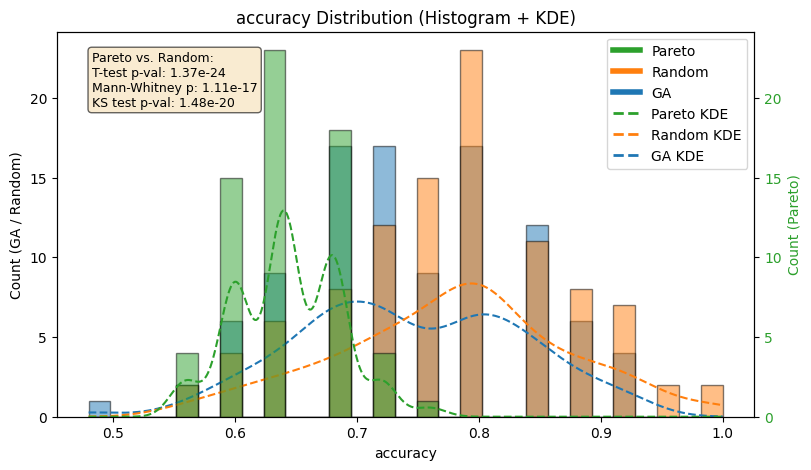

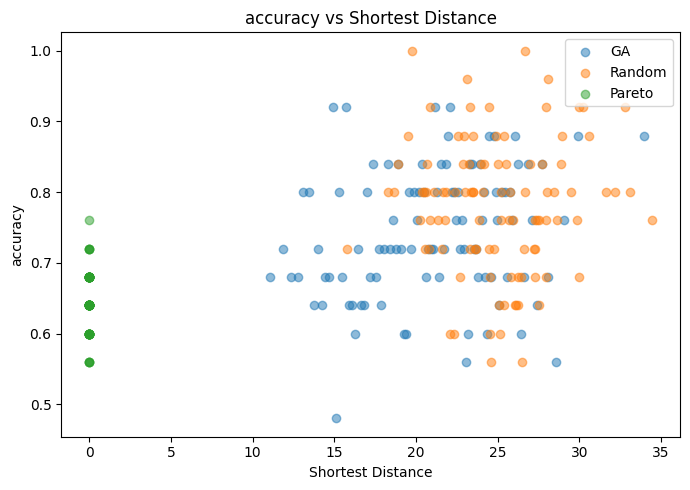

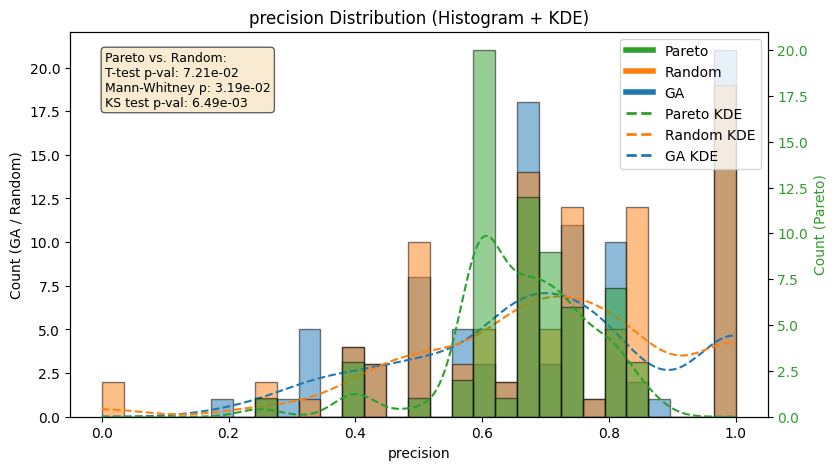

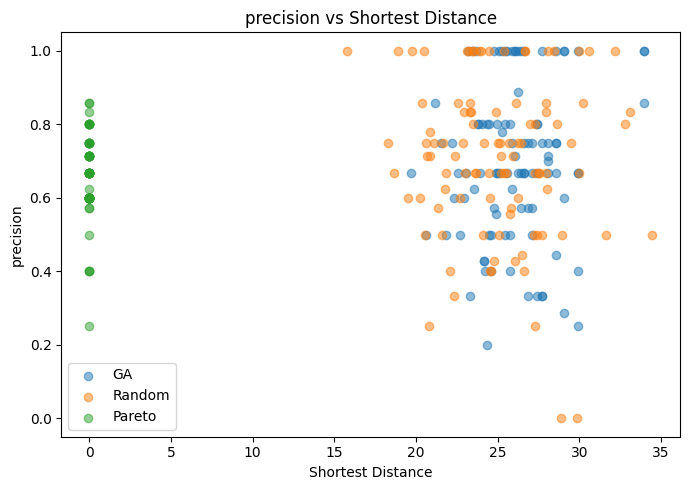

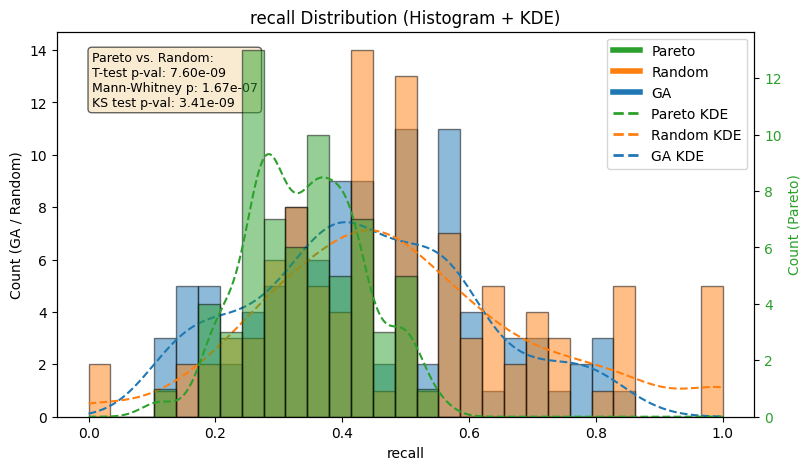

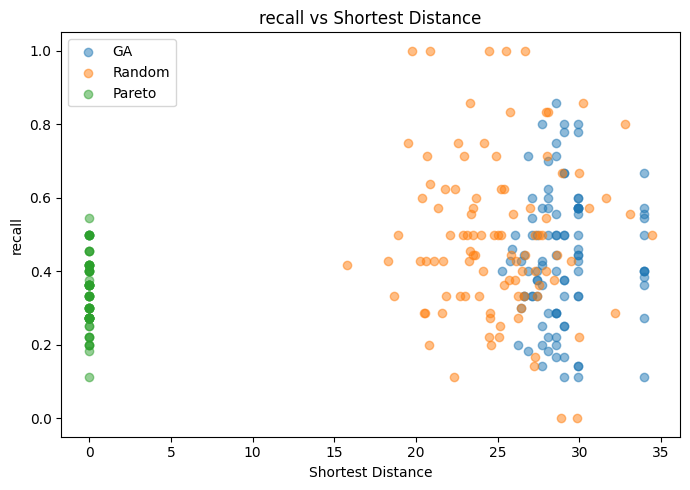

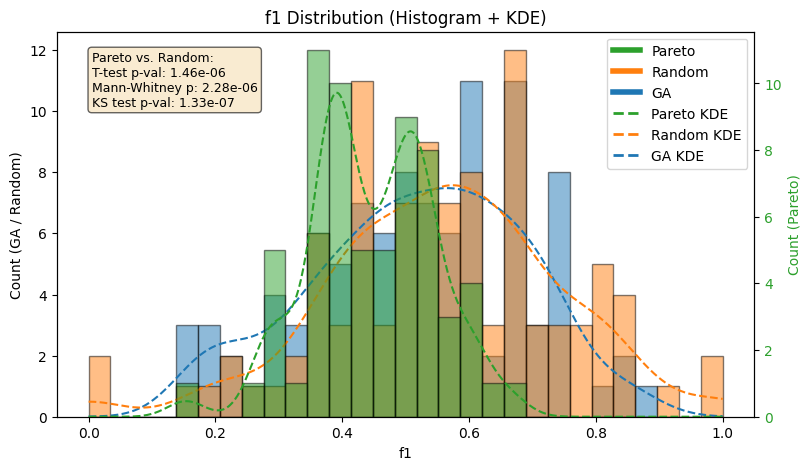

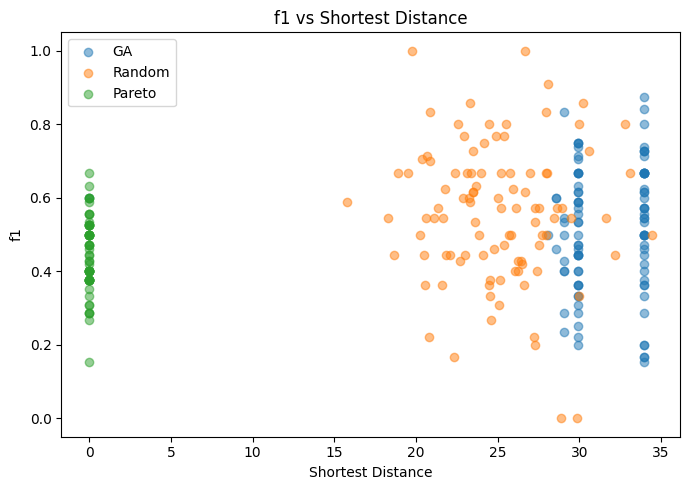

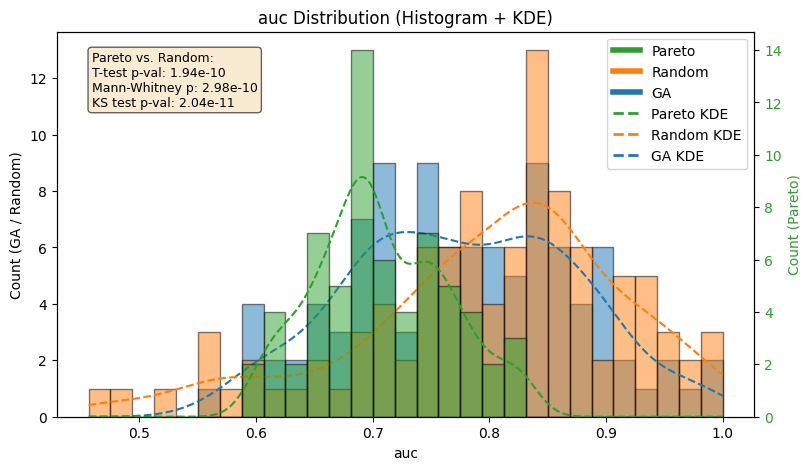

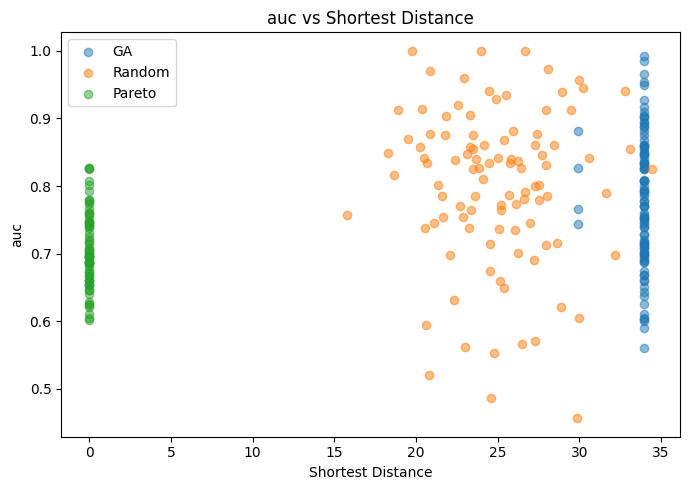

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, ttest_ind, mannwhitneyu

def safe_kde(data, bw=0.3):
    if np.std(data) == 0:
        return None
    try:
        return gaussian_kde(data, bw_method=bw)
    except Exception:
        return None

all_metrics = list(metrics_ga.keys())

for i in range(len(all_metrics)):
    use_metrics = list(metrics_ga.keys())[i]

    use_metrics_ga = metrics_ga[use_metrics]
    use_metrics_random = metrics_random[use_metrics]
    use_metrics_pareto = metrics_pareto[use_metrics]

    shortest_distances_ga, sampled_ga_indices = sample_extremely_non_uniformly_with_indices(
        shortest_distances_ga, 100
    )

    ga_score = np.array(use_metrics_ga)
    random_score = np.array(use_metrics_random)
    pareto_score = np.array(use_metrics_pareto)

    kde_pareto = safe_kde(pareto_score)
    kde_random = safe_kde(random_score)
    kde_ga = safe_kde(ga_score)

    xmin = min(min(pareto_score), min(random_score), min(ga_score))
    xmax = max(max(pareto_score), max(random_score), max(ga_score))
    x = np.linspace(xmin, xmax, 500)
    bins = np.linspace(xmin, xmax, 30)

    fig, ax1 = plt.subplots(figsize=(9, 5))

    ax1.hist(ga_score, bins=bins, alpha=0.5, color='tab:blue', label='GA', edgecolor='black')
    ax1.hist(random_score, bins=bins, alpha=0.5, color='tab:orange', label='Random', edgecolor='black')

    if kde_ga is not None:
        ax1.plot(x, kde_ga(x) * len(ga_score) * (bins[1]-bins[0]), '--', color='tab:blue')
    if kde_random is not None:
        ax1.plot(x, kde_random(x) * len(random_score) * (bins[1]-bins[0]), '--', color='tab:orange')

    ax1.set_xlabel(f"{use_metrics}")
    ax1.set_ylabel("Count (GA / Random)", color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    ax2.hist(pareto_score, bins=bins, alpha=0.5, color='tab:green', label='Pareto', edgecolor='black')
    if kde_pareto is not None:
        ax2.plot(x, kde_pareto(x) * len(pareto_score) * (bins[1]-bins[0]), '--', color='tab:green')

    ax2.set_ylabel("Count (Pareto)", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    ax1.set_title(f"{use_metrics} Distribution (Histogram + KDE)")
    ttest_stat, ttest_p = ttest_ind(pareto_score, random_score, equal_var=False) 
    mw_stat, mw_p = mannwhitneyu(pareto_score, random_score, alternative='two-sided')
    ks_stat, ks_p = ks_2samp(pareto_score, random_score)

    stats_text = (
        f"Pareto vs. Random:\n"
        f"T-test p-val: {ttest_p:.2e}\n"
        f"Mann-Whitney p: {mw_p:.2e}\n"
        f"KS test p-val: {ks_p:.2e}"
    )

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
    ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

    lines = [
        plt.Line2D([0], [0], color='tab:green', lw=4, label='Pareto'),
        plt.Line2D([0], [0], color='tab:orange', lw=4, label='Random'),
        plt.Line2D([0], [0], color='tab:blue', lw=4, label='GA'),
    ]
    if kde_pareto is not None:
        lines.append(plt.Line2D([0], [0], linestyle='--', color='tab:green', lw=2, label='Pareto KDE'))
    if kde_random is not None:
        lines.append(plt.Line2D([0], [0], linestyle='--', color='tab:orange', lw=2, label='Random KDE'))
    if kde_ga is not None:
        lines.append(plt.Line2D([0], [0], linestyle='--', color='tab:blue', lw=2, label='GA KDE'))

    ax1.legend(handles=lines, loc='upper right')

    plt.show()

    plt.figure(figsize=(7, 5))
    plt.scatter(shortest_distances_ga, use_metrics_ga, label='GA', alpha=0.5, color='tab:blue')
    plt.scatter(shortest_distances_random, use_metrics_random, label='Random', alpha=0.5, color='tab:orange')
    plt.scatter(shortest_distances_pareto, use_metrics_pareto, label='Pareto', alpha=0.5, color='tab:green')

    plt.xlabel("Shortest Distance")
    plt.ylabel(use_metrics)
    plt.title(f"{use_metrics} vs Shortest Distance")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
import pandas as pd
from itertools import combinations
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std
    
all_metrics = list(metrics_ga.keys())
all_results = []
alpha = 0.05

for use_metrics in all_metrics:
    scores = {
        "GA": np.array(metrics_ga[use_metrics]),
        "Random": np.array(metrics_random[use_metrics]),
        "Pareto": np.array(metrics_pareto[use_metrics])
    }

    for (name1, data1), (name2, data2) in combinations(scores.items(), 2):
        ks_stat, p_ks = ks_2samp(data1, data2)
        t_stat, p_t = ttest_ind(data1, data2, equal_var=False)
        u_stat, p_u = mannwhitneyu(data1, data2, alternative="two-sided")
        d = cohens_d(data1, data2)

        all_results.append({
            "Metric": use_metrics,
            "Group1": name1,
            "Group2": name2,
            "KS p-value": f"{p_ks:.3e}",
            "Cohen's d": f"{d:.3f}",
            "t-test p-value": f"{p_t:.3e}",
            "Mann-Whitney U p-value": f"{p_u:.3e}",
            "Significant?": "Yes" if (p_ks < alpha or p_t < alpha or p_u < alpha) else "No"
        })

df_stats_combined = pd.DataFrame(all_results)

df_stats_combined = df_stats_combined[[
    "Metric", "Group1", "Group2", "Cohen's d", "t-test p-value", 
    "Mann-Whitney U p-value", "KS p-value", "Significant?"
]]
# disp.display(df_stats_combined)

# run all test - analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, ttest_ind, mannwhitneyu

def safe_kde(data, bw=0.3):
    if np.std(data) == 0:
        return None
    try:
        return gaussian_kde(data, bw_method=bw)
    except Exception:
        return None

import pandas as pd
from itertools import combinations
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

In [10]:
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

from itertools import combinations

for test_num in tqdm(["0701", "0702", "0901", "0902", "0904", "0905", "0907", "1001", "1002"]):
    for lig in ["ago", "anta"]:
        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        trys = "241219_1"
        test_name = f"{test_num}_{lig}" if lig in ["ago", "anta"] else test_num
        path_template = f"../../data/result/{test_name}/GA_{trys}/distance_from_pareto"

        metrics_intermediate = pickle_load(f"{path_template}/ga/metrics_ga.pickle")
        metrics_random = pickle_load(f"{path_template}/random/metrics_random.pickle")
        metrics_ga_optimized = pickle_load(f"{path_template}/pareto/metrics_pareto.pickle")

        distances_intermediate = pickle_load(f"{path_template}/ga/shortest_distances_ga.pickle")
        distances_random = pickle_load(f"{path_template}/random/shortest_distances_random.pickle")
        distances_ga_optimized = pickle_load(f"{path_template}/pareto/shortest_distances_pareto.pickle")

        all_metrics = list(metrics_intermediate.keys())

        for use_metrics in all_metrics:
            scores = {
                "Intermediate (Non-Pareto)": np.array(metrics_intermediate[use_metrics]),
                "Random": np.array(metrics_random[use_metrics]),
                "GA-optimized (Pareto)": np.array(metrics_ga_optimized[use_metrics])
            }
            distances = {
                "Intermediate (Non-Pareto)": np.array(distances_intermediate),
                "Random": np.array(distances_random),
                "GA-optimized (Pareto)": np.array(distances_ga_optimized)
            }

            n_samples = len(scores["GA-optimized (Pareto)"])
            def sample_equal(arr, target_n):
                if len(arr) > target_n:
                    idx = np.random.choice(len(arr), target_n, replace=False)
                    return arr[idx]
                return arr

            sampled_scores = {k: sample_equal(v, n_samples) for k, v in scores.items()}
            sampled_distances = {k: sample_equal(v, n_samples) for k, v in distances.items()}

            xmin = min([np.min(v) for v in sampled_scores.values()])
            xmax = max([np.max(v) for v in sampled_scores.values()])
            x = np.linspace(xmin, xmax, 500)
            bins = np.linspace(xmin, xmax, 30)

            output_base = f"../../data/result/{test_name}/GA_{trys}"
            os.makedirs(f"{output_base}/fig5_with_intermediate", exist_ok=True)
            os.makedirs(f"{output_base}/fig5_no_intermediate", exist_ok=True)

            def make_plots(include_intermediate=True):
                groups = ["Random", "GA-optimized (Pareto)"]
                if include_intermediate:
                    groups.insert(1, "Intermediate (Non-Pareto)")

                colors = {
                    "Random": 'tab:orange',
                    "Intermediate (Non-Pareto)": 'tab:blue',
                    "GA-optimized (Pareto)": 'tab:green'
                }

                folder = "fig5_with_intermediate" if include_intermediate else "fig5_no_intermediate"
                output_dir = f"{output_base}/{folder}"

                fig, ax = plt.subplots(figsize=(10, 6))
                for g in groups:
                    ax.hist(sampled_scores[g], bins=bins, alpha=0.6, color=colors[g],
                            label=g, edgecolor='black')

                ax.set_xlim(xmin, xmax)
                ax.set_xlabel(f"{use_metrics}")
                ax.set_ylabel("Count")
                ax.set_title(f"Distribution of {use_metrics}" + (" (with Intermediate)" if include_intermediate else " (no Intermediate)"))
                ax.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/{use_metrics}_distribution.png", dpi=300)
                plt.close()

                # === Scatter ===
                plt.figure(figsize=(8, 6))
                for g in groups:
                    plt.scatter(sampled_distances[g], sampled_scores[g],
                                label=g, alpha=0.6, color=colors[g], s=60)

                plt.xlabel("Distance from Pareto Front")
                plt.ylabel(use_metrics)
                plt.title(f"{use_metrics} vs. Distance" + (" (with Intermediate)" if include_intermediate else " (no Intermediate)"))
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.savefig(f"{output_dir}/{use_metrics}_vs_distance.png", dpi=300)
                plt.close()

                plot_scores = {g: sampled_scores[g] for g in groups}
                alpha = 0.05
                all_results = []

                for (name1, data1), (name2, data2) in combinations(plot_scores.items(), 2):
                    ks_stat, p_ks = ks_2samp(data1, data2)
                    t_stat, p_t = ttest_ind(data1, data2, equal_var=False)
                    u_stat, p_u = mannwhitneyu(data1, data2, alternative="two-sided")
                    d = cohens_d(data1, data2)

                    all_results.append({
                        "Metric": use_metrics,
                        "Group1": name1,
                        "Group2": name2,
                        "Cohen's d": f"{d:.3f}",
                        "t-test p-value": f"{p_t:.3e}",
                        "Mann-Whitney U p-value": f"{p_u:.3e}",
                        "KS p-value": f"{p_ks:.3e}",
                        "Significant (p < 0.05)?": "Yes" if (p_t < alpha or p_u < alpha) else "No"
                    })

                df_stats = pd.DataFrame(all_results)
                df_stats.to_csv(f"{output_dir}/{use_metrics}_stats.csv", index=False)

            make_plots(include_intermediate=True)
            make_plots(include_intermediate=False)

        print(f"Finished {test_name}")

print("Processing finished.")


 11%|█         | 1/9 [00:09<01:16,  9.56s/it]

Finished 0701


 22%|██▏       | 2/9 [00:19<01:08,  9.81s/it]

Finished 0702
Finished 0901_ago


 33%|███▎      | 3/9 [00:54<02:09, 21.50s/it]

Finished 0901_anta
Finished 0902_ago


 44%|████▍     | 4/9 [01:26<02:08, 25.61s/it]

Finished 0902_anta
Finished 0904_ago


 56%|█████▌    | 5/9 [01:57<01:49, 27.30s/it]

Finished 0904_anta
Finished 0905_ago


 67%|██████▋   | 6/9 [02:28<01:25, 28.62s/it]

Finished 0905_anta


 78%|███████▊  | 7/9 [02:43<00:48, 24.34s/it]

Finished 0907


 89%|████████▉ | 8/9 [03:00<00:21, 21.78s/it]

Finished 1001


100%|██████████| 9/9 [03:15<00:00, 21.72s/it]

Finished 1002
Processing finished.
